# Train NN to get word difficulty level

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('../data/english/english.csv', newline='') as f:
    df = pd.read_csv(f)

In [3]:
df['length'] = df['word'].str.len()

In [4]:
df

,word,count,length
0,the,23135851162,3.0
1,of,13151942776,2.0
2,and,12997637966,3.0
3,to,12136980858,2.0
4,a,9081174698,1.0
...,...,...,...
333328,gooek,12711,5.0
333329,gooddg,12711,6.0
333330,gooblle,12711,7.0
333331,gollgo,12711,6.0


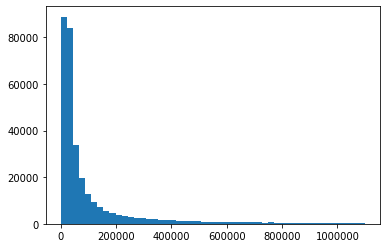

In [5]:
plt.hist(df['count'], range=(0, 1100000), bins=50)
plt.show()

In [6]:
df['level']=-1

## Add level using either one dataset

In [7]:
import csv
for i in range(0,9):
    with open(f'../data/english/flocabulary_{i}th_grade.csv', 'r') as f:
        csvreader = csv.reader(f)
        words = frozenset(list(csvreader)[0])
        df.loc[df['word'].isin(words), ['level']]=i

In [8]:
import csv
for i in range(5,13):
    with open(f'../data/english/greatschool_{i}th_grade.csv', 'r') as f:
        csvreader = csv.reader(f)
        words = frozenset(list(csvreader)[0])
        df.loc[df['word'].isin(words), ['level']]=i

In [7]:
import csv

for i in range(1,13):
    with open(f'../data/english/svl-processed-level-{i:02d}.csv', 'r') as f:
        csvreader = csv.reader(f)
        words = frozenset(list(csvreader)[0])
        df.loc[df['word'].isin(words), ['level']]=i

In [8]:
df['common']=0
commonwords = set(line.strip() for line in open('../data/english/commonwords.txt'))
df.loc[df['word'].isin(commonwords), ['common']] = 1

(array([ 128.,  293.,  460., 1376.,  899.,  971., 1959.,  998.,  997.,
         999.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

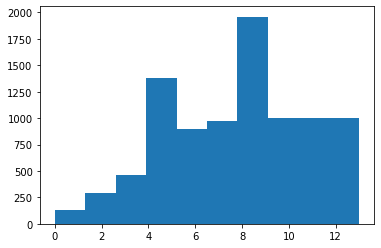

In [9]:
plt.hist(df[df['common']==0]['level'], range=(0,13))

(array([ 41., 864., 707., 540., 413., 210.,  99.,  29.,  32.,   8.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <a list of 10 Patch objects>)

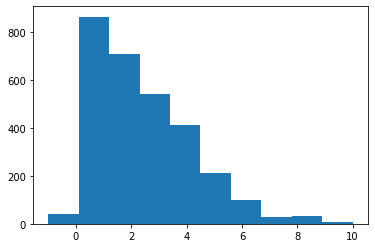

In [10]:
plt.hist(df[df['common']==1]['level'])

In [11]:
# add vowel column
df['vowel'] = 0
for c in ["a", "i", "u", "e", "o"]:
    df['vowel'] += df['word'].str.count(c)
df['vowel'] = df['vowel'] / df['length']

In [12]:
# add syllable column
df['syllable']=0
import syllables

def assign_syllable(row):
    if not pd.isna(row['word']):
        row['syllable']=syllables.estimate(row['word'])
    return row

from tqdm import tqdm
tqdm.pandas()
df = df.progress_apply(assign_syllable, axis=1)

C:\Users\Owner\Anaconda3\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████| 333333/333333 [01:34<00:00, 3525.92it/s]


In [13]:
df

,word,count,length,level,common,vowel,syllable
0,the,23135851162,3.0,1,1,0.333333,1
1,of,13151942776,2.0,1,1,0.500000,1
2,and,12997637966,3.0,1,1,0.333333,1
3,to,12136980858,2.0,1,1,0.500000,1
4,a,9081174698,1.0,1,1,1.000000,1
...,...,...,...,...,...,...,...
333328,gooek,12711,5.0,-1,0,0.600000,1
333329,gooddg,12711,6.0,-1,0,0.333333,1
333330,gooblle,12711,7.0,-1,0,0.428571,2
333331,gollgo,12711,6.0,-1,0,0.333333,2


In [14]:
df.to_csv("../data/english/preprocessed.csv",index=False)

In [15]:
#from string import ascii_lowercase
#for c in ascii_lowercase:
#    df[str(c)] = df['word'].str.count(c)

In [16]:
train_df = df[df['level']>=0].drop(['word'], axis=1)

In [17]:
train_df

,count,length,level,common,vowel,syllable
0,23135851162,3.0,1,1,0.333333,1
1,13151942776,2.0,1,1,0.500000,1
2,12997637966,3.0,1,1,0.333333,1
3,12136980858,2.0,1,1,0.500000,1
4,9081174698,1.0,1,1,1.000000,1
...,...,...,...,...,...,...
298285,15343,6.0,7,0,0.500000,2
302602,14937,8.0,12,0,0.500000,4
310889,14224,7.0,12,0,0.428571,3
321771,13380,9.0,10,0,0.333333,3


## Training

In [18]:
import tensorflow as tf

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df)

multiplied_by = scaler.scale_
added = scaler.min_

scaled_train_df = pd.DataFrame(scaled_train, columns=train_df.columns.values)

In [20]:
np.save("../model/mutiplied_by.npy", multiplied_by)
np.save("../model/added.npy", added)

In [21]:
x_train = train_df.drop(['level'], axis=1).values
y_train = train_df[['level']].values

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout

#build our model
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [24]:
X = scaled_train_df.drop('level', axis=1).values
Y = scaled_train_df[['level']].values

from tqdm.keras import TqdmCallback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="../model/weights.h5", verbose=0, save_best_only=True)

# Train the model
history = model.fit(
    X[100:],
    Y[100:],
    epochs=1000,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    verbose=0,
    callbacks=[TqdmCallback(verbose=0), checkpointer]
)

In [28]:
model.load_weights('../model/weights.h5')

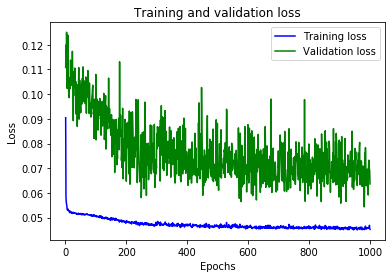

In [29]:
# Plotting Results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [30]:
model.evaluate(X[:100], Y[:100])

100/100 [==============================] - 0s 100us/step


0.04000940285623074

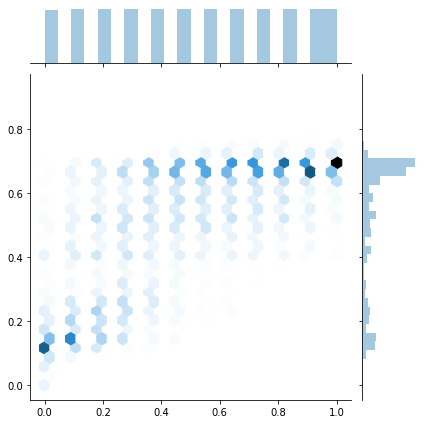

In [31]:
prediction = [y[0] for y in model.predict(X)]
prediction = [0 if p < 0 else p for p in prediction]
prediction = [1 if p > 1 else p for p in prediction]
target = [y[0] for y in Y]
import seaborn as sns
sns.jointplot(target, prediction, kind='hex')

In [32]:
model.save("../model/english.h5")
saved_model = keras.models.load_model("../model/english.h5")
saved_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________

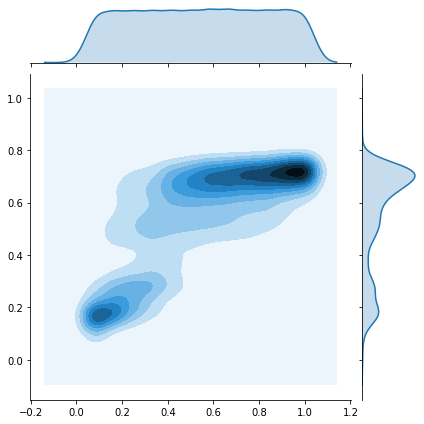

In [198]:
prediction = [y[0] for y in saved_model.predict(X)]
prediction = [0 if p < 0 else p for p in prediction]
prediction = [1 if p > 1 else p for p in prediction]
target = [y[0] for y in Y]
import seaborn as sns
sns.jointplot(target, prediction, kind='kde')

In [196]:
df

,word,count,length,level,vowel,syllable,common
0,the,23135851162,3.0,1,0.333333,1,1
1,of,13151942776,2.0,1,0.500000,1,1
2,and,12997637966,3.0,1,0.333333,1,1
3,to,12136980858,2.0,1,0.500000,1,1
4,a,9081174698,1.0,1,1.000000,1,1
...,...,...,...,...,...,...,...
333328,gooek,12711,5.0,-1,0.600000,1,0
333329,gooddg,12711,6.0,-1,0.333333,1,0
333330,gooblle,12711,7.0,-1,0.428571,2,0
333331,gollgo,12711,6.0,-1,0.333333,2,0


In [215]:
prediction = model.predict(X[:10000])
y_0 = prediction[1004][0]
print(y_0)
y_0 -= added[2]
y_0 /= multiplied_by[2]
print(y_0)

0.53193676
6.383241176605225
